In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

def p( x, temperature=1.0 ):
    return np.exp( -10*temperature*((x-2)**2) ) + 0.3*np.exp( -0.5*10*temperature*((x+1)**2) )

def Q( x, var ):
    return np.random.normal(x, var)

def plot(xs, y, title):
    ax = plt.subplot(title=title)
    for x in xs:
        ax.plot(y, x)
    plt.ylabel('State')
    plt.xlabel('Time')
    plt.show()
    
def hist(xs, bins, title):
    x = xs.flatten()
    ax = plt.subplot(title=title)
    ax.hist(x, bins, normed=True)
    y = np.arange(-3, 3, 6/bins)
    ax.plot(y, p(y))
    plt.xlim(-3, 3)
    plt.show()

Part 1: Metropolis Hastings
(three histograms, three evolution plots)

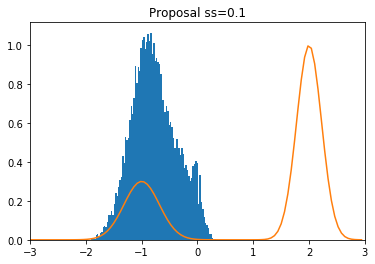

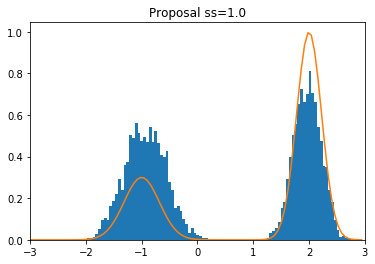

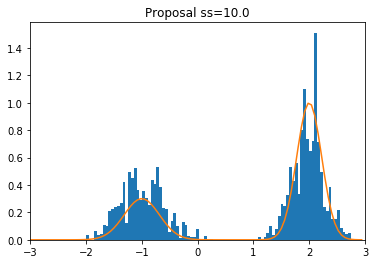

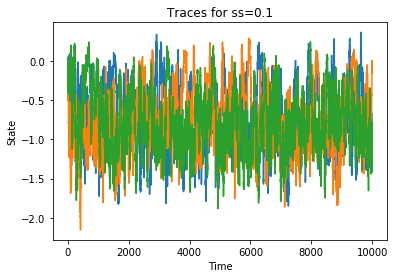

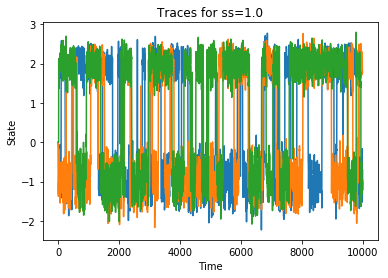

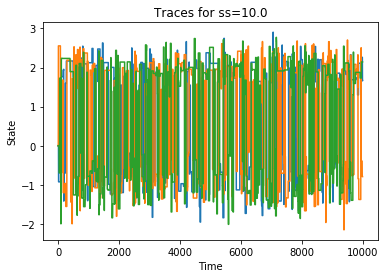

Total Acceptance Rate: 1.124


In [4]:
ss = [0.1, 1.0, 10.0]
steps = 10000
chains = 3
x_store = []
acceptance = 0

for s in ss:
    xs = np.zeros((chains, steps))
    for t in range(steps-1):
        for c in range(chains):
            x = xs[c, t]
            x_p = Q(x, s)
            alpha = (p(x_p) * Q(x, s)) / (p(x) * Q(x_p, s))
            r = np.min([1, alpha])
            u = np.random.uniform(0, 1)
            if u < r:
                acceptance += 1
                xs[c, t+1] = x_p
            else:
                xs[c, t+1] = xs[c, t]
    hist(xs, 100, 'Proposal ss=%.1f' % s)
    x_store.append(xs)

for i in range(len(ss)):
    plot(x_store[i], range(steps), 'Traces for ss=%.1f' % ss[i])
print('Total Acceptance Rate: %.3f' % (acceptance / (steps * chains)))

Part 2: Hamiltonian MCMC
(one histogram, one evolution plot)

In [317]:
def U(q):
    return -np.log(p(q))

def HMC(U, grad_U, epsilon, L, current_pos, var, acceptance):
    # step 1: change momentum
    new_pos = current_pos
    new_mom = Q(new_pos, var)
    current_mom = new_mom
    # leapfrog
    new_mom -= epsilon * grad_U(new_pos) / 2
    for i in range(1, L):
        # full step for position
        new_pos += epsilon * new_mom
        if i != L: 
            new_mom -= epsilon * grad_U(new_pos)
    new_mom -= epsilon * grad_U(new_pos) / 2
    #new_mom = -new_mom
    #step 2: change position if good proposal
    current_U = U(current_pos)
    current_K = np.sum(current_mom*current_mom) / 2
    proposed_U = U(new_pos)
    proposed_K = np.sum(new_mom*new_mom) / 2
    alpha = np.exp((current_U - proposed_U) + (current_K - proposed_K))
    if 1 < alpha:
        acceptance += 1
        return new_pos, acceptance
    else:
        return current_pos, acceptance

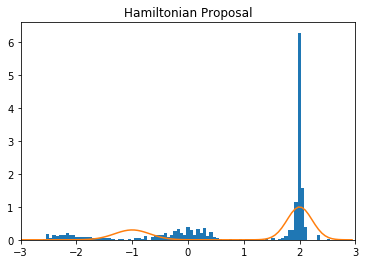

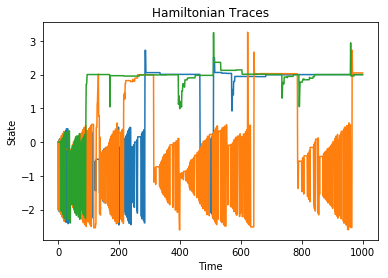

Total Acceptance Rate: 0.195


In [318]:
import autograd.numpy as np
from autograd import grad
grad_p = grad( p )
grad_U = grad( U )

steps = 1000 #10,000?
chains = 3
xs = np.zeros((chains, steps))
epsilon = 0.11
L = 100
var = 1.5
acceptance = 0

for t in range(steps-1):
    for c in range(chains):
        xs[c, t+1], acceptance = HMC(U, grad_U, epsilon, L, xs[c, t], var, acceptance)
            
hist(xs, 100, 'Hamiltonian Proposal')
plot(xs, range(steps), 'Hamiltonian Traces')
print('Total Acceptance Rate: %.3f' % (acceptance / (steps * chains)))

Part 3: Observations

    The acceptance rate of the Metropolis-Hastings algorithm was 74.4%
    The acceptance rate of the Hamiltonian algorithm was 19.5%

Some inference algorithms don't explore both modes of density because they can't escape a local min or max. Some algorithms stay in the same state repeatedly because the acceptance criteria is not met, which is usually bad.

For the Hamiltonian MCMC, the best value for the variance of the momentum variables was 1.75, and the best timestep I found was 0.05. I knew that these were good values because the resulting histogram most closely matched the actual distribution.